# Point Patterns Quadrat Counts

Created by: Derek Robinson <br>
Last Updated: January 20, 2021

### Learning Objectives

In this Jupyter Notebook you will learn or review how to
<ul>
    <li> generate a grid of quadrats (i.e., polygons), </li>
    <li> clip quadrats to another shapefile to generate a subset of quadrats,</li>
    <li> perform an overlay to retrieve point counts within polygons, </li>
    <li> sum point features within each quadrat, </li>
    <li> count the number of qudrats with the same number of points, </li>
    <li> calculate the mean and variance of the number of points in quadrats,</li>
    <li> calculate the mean to variance ratio to assess the spread of points,</li>
    <li> plot maps, </li> 
    <li> conduct spatial analysis using R. </li>
</ul>

### Assignment Completion

For those in GEOG 318/PLAN 353 @UWaterloo, the assignment directions and submission requirements are provided on LEARN as a quiz that spans multiple days. To complete the quiz/assignment you will need to do the following:

<ul>
    <li> Complete this Jupyter Notebook.</li>
    <ul>
        <li> To advance to the next text cell or execute the code in a cell hold <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">Shift</mark></font> and press <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">Enter</mark></font> </li>
        <li> If there is a method for which you would like to know more about its parameters or how it works then you can place your cursor on the method and press <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">Shift + Tab</mark></font> and a help box will appear that you can expand and scroll through.</li>
    </ul>
    <li> Complete the Quadrat Analysis Quiz/Assignment in LEARN, which may require you to </li>
    <ul>
        <li> copy results from your notebook into the LEARN input boxes, </li>
        <li> take screen captures of your notebook output and submit them via LEARN, or </li>
        <li> change values in the Jupyter Notebook and re-execute cells/code to obtain new results. </li>
    </ul>
    <li> <b>While you may discuss course content with your classmates, you are to complete the assignment individually.</b></li>
</ul>

### Problem Statement & Data

The quadrat count and analysis methods below use point pattern data of Home Depot stores located in Ontario, Canada, in 2014. In this Notebook you will perform quadrat counts and derive the variance-to-mean ratio to compare your point patten against the Poisson distribution. This comparison is one way to objectively determine if the data are clustered or evenly spread out. 

**While the methods below use store location data, they are applicable to point data representing other phenomena (e.g., wetland, wildlife, school, or crime locations).** For example, similar methods were used by Owen Royall in Biology to count the number of wetlands in different sized quadrats and determine if there was spatial clustering of wetlands https://uwspace.uwaterloo.ca/handle/10012/15980.

### Lets get started
Sometimes when running functions and code in R you will receive warnings. These are displayed in pink in Jupyter Notebook following the execution of a cell. The warnings arise for a variety of reasons like a parameter was not specified so a default will be used. In creating these notebooks I have reviewed the warnings and they do not affect the results. The next line of code turns them off so that you are not confused or worried about them. However, if you would like to see them you may restart the notebook and comment the following cell code or skip executing it.

In [ ]:
options(warn=-1)
# command to turn warnings on
# options(warn=0)

We need to use several methods in the `rgdal` and `spatstat` packages. First try loading the packages into your r library and if you get an error then uncomment the install commands and install the packages.


In [1]:
#install.packages("spatstat")
#install.packages("rgdal")
library(spatstat)
library(rgdal)

Loading required package: spatstat.data

Loading required package: nlme

Loading required package: rpart


spatstat 1.64-1       (nickname: ‘Help you I can, yes!’) 
For an introduction to spatstat, type ‘beginner’ 



Note: spatstat version 1.64-1 is out of date by more than 9 months; we recommend upgrading to the latest version.

Loading required package: sp

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.1, released 2020/06/22
Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/4.0/Resources/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /Library/Frameworks/R.framework/Versions/4.0/Resources/library/rgdal/proj
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before l

Load the shapefile of Home Depot store point locations and store it in a variable named OHD.

OGR data source with driver: ESRI Shapefile 
Source: "/Users/dtrobins/Documents/workspace/jupyterStats/courses-UWaterloo-318/QuadratAnalysis/OntarioHomeDepot.shp", layer: "OntarioHomeDepot"
with 89 features
It has 15 fields


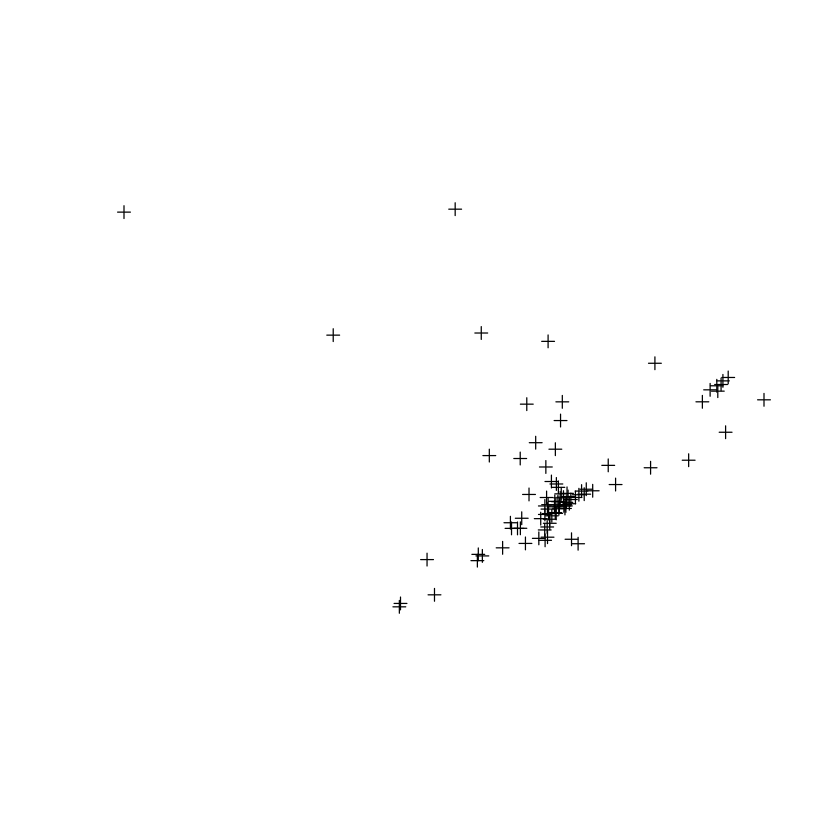

In [2]:
OHD <- readOGR("OntarioHomeDepot.shp", "OntarioHomeDepot")
plot(OHD)

Load the shapefile of the province of Ontario and store it in a variable named ONP.

In [3]:
ONP <- readOGR(dsn="OntarioProvince.shp", layer="OntarioProvince")
# You can plot the provincial layer similar to the points above.
# However, it takes a long time to render the the provincial data. So if you do this, be patient.
# plot(ONP)

OGR data source with driver: ESRI Shapefile 
Source: "/Users/dtrobins/Documents/workspace/jupyterStats/courses-UWaterloo-318/QuadratAnalysis/OntarioProvince.shp", layer: "OntarioProvince"
with 1 features
It has 9 fields


We are going to <b>generate a grid of quadrats</b> that will cover or tesselate our entire study area, which is the province of Ontario. First we need to acquire the spatial extent of the Province of Ontario data. The spatial extent information of the Province shapefile is in our new `ONP` object under the `bbox` attribute. Use the following code to print and see the coordinates that define the spatial extent of the OntarioProvince.shp file data.

In [4]:
print (ONP@bbox)

         min      max
x   197256.4  1763709
y 11676337.8 13367251


Each of the values defining the spatial extent (i.e., bounding box) is stored in an element of a bounding box vector. Therefore we can acquire the minimum X and Y and maximum X and Y coordinates using the following code: 

In [5]:
ONP_minX <- ONP@bbox[1]
ONP_minY <- ONP@bbox[2]
ONP_maxX <- ONP@bbox[3]
ONP_maxY <- ONP@bbox[4]
print (paste(ONP_minX, ONP_maxX))
print (paste(ONP_minY, ONP_minY))

[1] "197256.409199998 1763709.2426"
[1] "11676337.8174 11676337.8174"


The print commands should show the same values as you observed above with `print@bbox`.<br>

Next we are going to create a point pattern dataset `(ppp)` object using the `spatstat` library. This ppp object will hold the locations of the store points, but we are going to assign it the spatial extent (i.e., bounding box) of the Province of Ontario shapefile data. We give the `ppp()` function the following arguments x-coordinates, y-coordinates, a two element vector of min and max x values, and a two element vector of the min and max y values. 

See the following webpage for more about the concatenate `c()` function https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/c

Then we will print our new ppp object `OHD_ppp`. Verify that this object contains the correct number of points and that it has acquired the correct bounding box coordinates.

In [6]:
OHD_ppp <- ppp(OHD$X, OHD$Y, c(ONP_minX,ONP_maxX), c(ONP_minY, ONP_maxY))
print (OHD_ppp)

Planar point pattern: 89 points
window: rectangle = [197256.4, 1763709.2] x [11676338, 13367251] units


Now that both our point and province data have the same spatial extent defined, we have to generate a window object of this spatial extent to use in our analysis later. Why do we have to do this? Each person or team of developers that create the packages we are using stipulates the format the data and parameters (or arguments) for their function to work. Because we're working with the `spatstat` package and it requires an `owin` object for the quadrat analysis we would like to do, we have to create one. Since we are working with the spatial extents here to create the point pattern object its easiest to also define a window object representing our spatial extent.<br><br>
Using the bounding box information we can specify a window of the spatil extent of the province of Ontario as follows:

In [ ]:
ONP_win <- owin(xrange=c(ONP@bbox[1], ONP@bbox[3]), yrange=c(ONP@bbox[2], ONP@bbox[4]), poly=NULL,units="m")

Something to note here is that the object window function (i.e., owin) uses a range of x coordinates and a range of y coordinates and not a minimum x, y coordinate and maximum x,y coordinate the way a typical GISystem would. You have to be careful with the specification of inputs on new objects you are working with. This one threw me for about two hours and forced me to review projections and all other aspects of the code. Because it took me a while to figure out how the owin() function worked, I’ve explicitly specified the input parameters and variables that state <ol><li> the range of x coordinates (xrange =),</li> <li>the range of y coordinates (yrange =),</li><li> no polygon around the window (poly=NULL), and </li><li> what units we are working with (units=”m”).</li></ol>

The next two required inputs for creating quadrats are vectors of the x-coordinates and y-coordinates that identify where the quadrats should be created (i.e., breaks). To identify these coordinates we also need to determine the size of the quadrats. Lets use 50 km x 50 km, which is 50,000 m x 50,000 m since our projection is in metres. We will use a while loop to iterate through the creation of new x and y coordinate break points until we extend beyond the maximum x coordinate in our bounding box. 

To do this lets first define the resolution of our quadrats

In [ ]:
quadratResolution <- 50000

Then we will create an empty vector that will hold all the break points for our quadrats in the x direction.

In [ ]:
xQuadratBreaks <- c()

Then we set the location of the first x-coordinate for the quadrat grid to be created as the minimum x-coordinate in our Ontario shapefile.

In [ ]:
x_break <- ONP_minX

Then we can add our quadrat resolution (in metres) to the minimum x-coordinate and create a new break point there, repeating until we extend beyond the maximum x-coordinate. This can be done with the following code:

In [ ]:
# while our break coordinate is less than the maximum X coordinate plus the quadratResolution repeat the loop

while (x_break < ONP_maxX + quadratResolution) {
  # append to our empty vector (using the concatenate function) the value of our next x_break
  xQuadratBreaks <- c(xQuadratBreaks, x_break)
  # increase the value of the x_break coordinate by 50,000 m
  x_break <- x_break + quadratResolution
}

Repeat the process for creating a vector of y-coordinate break points.

In [ ]:
yQuadratBreaks <- c()
y_break <- ONP_minY
while (y_break < ONP_maxY + quadratResolution) {
  yQuadratBreaks <- c(yQuadratBreaks, y_break)
  y_break <- y_break + quadratResolution
}

Now you can create and plot the quadrats as a tessellation of squares with a width and height = `quadratResolution` that covers the spatial extent of the province of Ontario using the `quadrats()` function from the `spatstat` package.

In [ ]:
plot.new()
OHD_quadrats <- quadrats(ONP_win, xbreaks = xQuadratBreaks, ybreaks = yQuadratBreaks)
plot(OHD_quadrats)

Next we will use the `over` function to identify which quadrats overlap the province and which ones do not. Then we will remove those that do not overlap the province. To convert our quadrats to a spatial data frame for spatial analysis we need to use the `as()` function provided by the `maptools` package. Load the `maptools` library or install it if you do not already have it installed. 

In [ ]:
#install.packages("maptools")
library(maptools)

Once you have done this then you can use the following code to convert (i.e., coerce) your quadrats to `SpatialPolygons`

In [ ]:
OHD_quadrats_sp <- as(OHD_quadrats, "SpatialPolygons")

Now that we have spatial objects, we have to give those objects spatial reference information or the functions working with the data won’t know how to determine appropriate locations and calculate distances. We can do this by assigning the spatial reference information for the province to our new SpatialPolygons quadrats object.

In [ ]:
proj4string(OHD_quadrats_sp) <- proj4string(ONP)

Now that the OHD_quadrats_sp has spatial reference information <b>we can subset our quadrats</b> by those that intersect the Province of Ontario boundary using the square bracket `[]` subsetting approach.

In [ ]:
OHD_quadrat_subset <- OHD_quadrats_sp[ONP,]
plot.new()
plot(OHD_quadrat_subset)

Using the above code you <b>clipped the quadrats to the Province of Ontario</b>. Let's improve our map presentation using the following three libraries, overlay our data layers, and add coordinates, axes, and labels. This will allow us to see how the provincial boundary, quadrats, and points all looks together.

In [ ]:
library(ggplot2)
library(ggspatial)

In [ ]:
# ggplot requires a dataframe object for our points data so we have to create this new object
OHD_data <- data.frame(OHD)

g <- ggplot() + geom_polygon(data=ONP, aes(x=long, y=lat, group=group), color="black", fill=NA)
g1 <- g + geom_polygon(data=OHD_quadrat_subset, aes(x=long, y=lat, group=group), colour="blue", fill=NA) 
g2 <- g1 + geom_point(data=OHD_data, aes(x=X, y=Y), color="orange")
g3 <- g2 + xlab("Longitude") + ylab("Latitude") + ggtitle("HD Stores and 100k Quadrats") + annotation_scale(location = "bl", width_hint = 0.5)
plot(g3)

With our new set of quadrats we can now <b>count the number of points (stores) within each quadrat</b> using the `over()` function. Remember the purpose of our quadrat analysis is to objectively determine if the pattern differs from one that would be obtained from random. The comparison of two patterns requires our calculation of the number of unique counts of events in quadrats (k), the quadrat count distribution (i.e., the number of quadrats by number of events, x), and the average event per quadrat (i.e., greek letter mu in the textbook). With this information we can calculate the variance and assess if the pattern is clustered, random, or evenly dispersed using the variance-to-mean ratio. 

First, lets get a count of all the quadrats that we’re working with that intersect the province of Ontario.

In [ ]:
OHD_quadrat_subset_count <- length(OHD_quadrat_subset)
print (OHD_quadrat_subset_count)

We can intersect the Home Depot stores with the Ontario quadrats using the `over()` function from `spatstat` and create a new spatial data frame of Home Depot stores that have the quadrat ID number of the quadrat it is within.

In [ ]:
HDstore_quadratID <- over(OHD, OHD_quadrat_subset)
print(HDstore_quadratID)

We can then summarize our data using the `table()` function, which is equivalent to the `as.factor()` function. The table function will count the number of events (i.e., stores) in each quadrat that has an event. 

In [ ]:
HDStore_quadrat_tabulation <- table(HDstore_quadratID)

Try <b>printing out the tabulation</b> to review this step and to ensure you know what is happening. This is similar to right clicking on an attribute in the attribute table in ArcGIS and selecting summarize and then choosing to sum that variable by quadrat ID.

In [ ]:
print(HDStore_quadrat_tabulation)

At this point our table does not contain information about the count of quadrats with zero events. We need this information to properly calculate the variance and assess our point pattern. To do this we will first calculate the number of quadrats with events

In [ ]:
OHD_quadrat_subset_w_store_count <- nrow(HDStore_quadrat_tabulation)
print(OHD_quadrat_subset_w_store_count)

Remember we used the `nrow()` function earlier to count the number of features or events in a data frame. Now we have the total number of quadrats as we determined a couple of steps above and we just determined the number of quadrats with stores. Subtract one from the other to obtain the number of quadrats without stores and call the variable OHD_quadrat_subset_wo_store_count. Print out your results to verify that your numbers are correct. I used the paste function to concatenate text and variables like the following example:

In [ ]:
print(paste("number of total quadrats = ", OHD_quadrat_subset_count, " number of quadrats with stores = ", OHD_quadrat_subset_w_store_count))

In [ ]:
OHD_quadrat_subset_wo_store_count <- OHD_quadrat_subset_count - OHD_quadrat_subset_w_store_count
print(paste("number of quadrats without stores = ", OHD_quadrat_subset_wo_store_count))

To acquire the distribution of quadrat values we will perform a tabulation (summary) on the table we created above. This will provide a <b>count of the number of quadrats with the same number of events</b>.

In [ ]:
HDStore_quadrat_distribution <- table(HDStore_quadrat_tabulation)

Review your results using the print command. You will see two rows of information. The first row is a row of column names. Normal functions will not retrieve this information, but we want that information because it is telling us how many events are in a quadrat. The second row is telling us how many quadrats have the number of events in the name.

In [ ]:
print(HDStore_quadrat_distribution)

To convert the names to a vector of numbers use the following complex command:

In [ ]:
HDStore_no_of_events_k <- as.vector(as.numeric(names(table(table(HDstore_quadratID)))))
#print (HDStore_no_of_events_k)

The `names()` function only works with the result of our tabulation process, so we have to duplicate the two tabulations to extract the names. However, note how several functions are nested, which also reduces the length of code. However, many also find that nesting functions can make the code more difficult to follow. 

The `as.numeric()` function is applied to our `names` to convert them to numbers and apply the `as.vector()` function to retrieve a vector of these event counts and store it in a variable called `HDStore_no_of_events_k`, which corresponds to `k` in the textbook on page 130.

Next, create a vector of the frequency of quadrats with different event (i.e., store) counts using the `as.vector()` function on our summary data as follows:

In [ ]:
HDStore_no_of_quadrats_x <- as.vector(HDStore_quadrat_distribution)
HDStore_no_of_quadrats_x

We almost have all the values we need for k and x in Table 3 below. To complete those columns we need to include the count of quadrats that have zero events (i.e., stores). Use the following c() function to combine your OHD_quadrat_subset_wo_store_count to the front of your HDStore_no_of_quadrats_x variable.

In [ ]:
HDStore_no_of_quadrats_x <- c(OHD_quadrat_subset_wo_store_count,HDStore_no_of_quadrats_x)

Add the corresponding event count information (i.e., these are quadrats with zero events) to the front of your HDStore_no_of_events_k variable using the following code:

In [ ]:
HDStore_no_of_events_k <- c(0, HDStore_no_of_events_k)

Print your new variables to observe that the event count and quadrat counts match as you would expect.

In [ ]:
print(HDStore_no_of_quadrats_x)
print(HDStore_no_of_events_k)

Next lets check to verify the number of quadrats in our new variable is the same as our initial number of quadrats.

In [ ]:
print (sum(HDStore_no_of_quadrats_x))

and verify that the number of events (i.e., stores) is the same as our initial number

In [ ]:
print (sum(HDStore_no_of_quadrats_x * HDStore_no_of_events_k))

Now we can calculate the mean quadrat count, also known as mu in the text Page 130

In [ ]:
mu <- nrow(OHD)/sum(HDStore_no_of_quadrats_x)
print(mu)


We can now <b>calculate the observed variance</b> as described on page 130 of the textbook using the following equation: 
![image](Observed_Variance.png)
First we will subtract the average number of events per quadrat `μ (mu)` from the observed number of stores found in different quadrats <br>(i.e., `HDStore_no_of_events_k`).

In [ ]:
k_minus_mu <- HDStore_no_of_events_k - mu
#print(k_minus_mu)

Next we can square these difference values. We are calculating the numerator for our variance <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">s<sup>2</sup></mark></font> equation above.

In [ ]:
k_minus_mu_sqrd <- k_minus_mu^2
#print(k_minus_mu_sqrd)

Next we multiply our number of quadrats with different events (i.e., `HDStore_no_of_quadrats_x`) against (K - μ)<sup>2</sup>.

In [ ]:
x_times_k_minus_mu_sqrd <- HDStore_no_of_quadrats_x*k_minus_mu_sqrd
#print(x_times_k_minus_mu_sqrd)

And `sum()` all those values to complete the numerator

In [ ]:
variance_numerator <- sum(x_times_k_minus_mu_sqrd)

The denominator is simply the number of quadrats `m` minus 1.

In [ ]:
variance_denominator <- OHD_quadrat_subset_count - 1
# print(variance_denominator)

Our final variance value is the numerator devided by the denominator

In [ ]:
variance <- variance_numerator/variance_denominator
# print(variance)

Now that we have the variance calculated, we can <b>calculate the variance-to-mean ratio (VMR)</b> by dividing the variance (s2) by the mean (`μ`). Remember that a property of the Poisson distribution from an independent random process (IRP) is that the mean and variance are equal and therefore the VMR is 1.0. A VMR > 1.0 indicates a tendency toward clustering in the observations and a VMR < 1.0 indicates a more evenly spaced arrangement. 

In [ ]:
vmr <- variance/mu
vmr

# Congratulations!

**You have reached the end of the Spatial Summary Statistics notebook**